In [46]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from shared_utilities import helpers

In [3]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

NGSB-DTFB
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [7]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [8]:
conn = helpers.get_redshift_connection("qa-app", "stlrlagalaxy")

In [12]:
cursor = conn.cursor()
sql = "SELECT * FROM dw.cohortpurchase"
cursor.execute(sql)



In [13]:
data = cursor.fetchall()

In [19]:
df_original = pd.DataFrame(data=data, columns=[desc[0] for desc in cursor.description])

In [21]:
cursor.close()
conn.close()

In [28]:
df = df_original.copy()

## Cleaning

We can group by to see aggregations absed on the product groupings. We can see that some have a (min, max) range of (0, 0) which won't be applicable for us, so we can remove those.

We can also create a year and month column, if we wanted to do any analysis on a particular month or year.

In [33]:
(df
    .groupby(['productgrouping'])
    .agg({
        'dimcustomermasterid': ['count'],
        'revenue': ['min', 'max', 'mean', 'median', 'sum'],
        'daysoutfromevent': ['min', 'max', 'mean', 'median', 'sum']
    })
)

dimcustomermasterid revenue                                \
                                 count     min        max        mean median   
productgrouping                                                                
Comp                             53692     0.0       0.00    0.000000    0.0   
Full Season                     533852     1.9    7450.00   86.019333   55.5   
Group                            75412     2.5   39200.00  298.870853   80.0   
Individual                      172723     0.0  437473.69  180.252718   80.0   
Mini Plan                        22216     0.0    4000.00   95.048724   74.0   
Other                              694     0.0    6465.00  499.032061    0.0   
Partial Plan                     30454     5.0    1450.00   92.041029   71.0   
Premium Membership               24933     0.0       0.00    0.000000    0.0   
Premium Purchase                  2045     0.0       0.00    0.000000    0.0   

                                daysoutfromevent                            \
                            sum              min    max        mean median   
productgrouping                                                              
Comp                       0.00              0.0  541.0  100.778701   24.0   
Full Season         45921593.17              0.0  738.0  296.278685  292.0   
Group               22538448.75              0.0  706.0   19.502461    6.0   
Individual          31133790.28             -5.0  457.0   22.066413    7.0   
Mini Plan            2111602.46              0.0  457.0   60.515327   39.0   
Other                 346328.25              0.0  216.0   26.233645   11.0   
Partial Plan         2803017.50              0.0  756.0  138.517263  128.0   
Premium Membership         0.00              0.0  510.0  279.194682  282.0   
Premium Purchase           0.00              0.0  411.0   39.808313   16.0   

                                 
                            sum  
productgrouping                  
Comp                  5411010.0  
Full Season         158166302.0  
Group                 1470310.0  
Individual            3802705.0  
Mini Plan             1344348.0  
Other                    5614.0  
Partial Plan          4216604.0  
Premium Membership    6961161.0  
Premium Purchase        81408.0

In [38]:
df = df[~df['productgrouping'].isin(['Comp', 'Premium Membership', 'Premium Purchase', 'Other'])]

In [39]:
(df
    .groupby(['productgrouping'])
    .agg({
        'dimcustomermasterid': ['count'],
        'revenue': ['min', 'max', 'mean', 'median', 'sum'],
        'daysoutfromevent': ['min', 'max', 'mean', 'median', 'sum']
    })
)

dimcustomermasterid revenue                                \
                              count     min        max        mean median   
productgrouping                                                             
Full Season                  533852     1.9    7450.00   86.019333   55.5   
Group                         75412     2.5   39200.00  298.870853   80.0   
Individual                   172723     0.0  437473.69  180.252718   80.0   
Mini Plan                     22216     0.0    4000.00   95.048724   74.0   
Partial Plan                  30454     5.0    1450.00   92.041029   71.0   

                             daysoutfromevent                            \
                         sum              min    max        mean median   
productgrouping                                                           
Full Season      45921593.17              0.0  738.0  296.278685  292.0   
Group            22538448.75              0.0  706.0   19.502461    6.0   
Individual       31133790.28             -5.0  457.0   22.066413    7.0   
Mini Plan         2111602.46              0.0  457.0   60.515327   39.0   
Partial Plan      2803017.50              0.0  756.0  138.517263  128.0   

                              
                         sum  
productgrouping               
Full Season      158166302.0  
Group              1470310.0  
Individual         3802705.0  
Mini Plan          1344348.0  
Partial Plan       4216604.0

In [61]:
df['month'] = df['eventdate'].dt.month
df['month'].sample(10)

292968     8.0
146759     8.0
33335      7.0
497461     5.0
483743     4.0
805492     8.0
459372     8.0
674601    10.0
83758      7.0
556710     9.0
Name: month, dtype: float64

In [58]:
df['year'] = df['eventdate'].dt.year
df['year'].sample(10)

801941    2020.0
313440    2016.0
566903    2021.0
43687     2012.0
392156    2017.0
366504    2017.0
68950     2013.0
241428    2014.0
742310    2023.0
191379    2014.0
Name: year, dtype: float64

## Visualizations

### Line Plot


Text(0.5, 1.0, 'Revenue By Date')

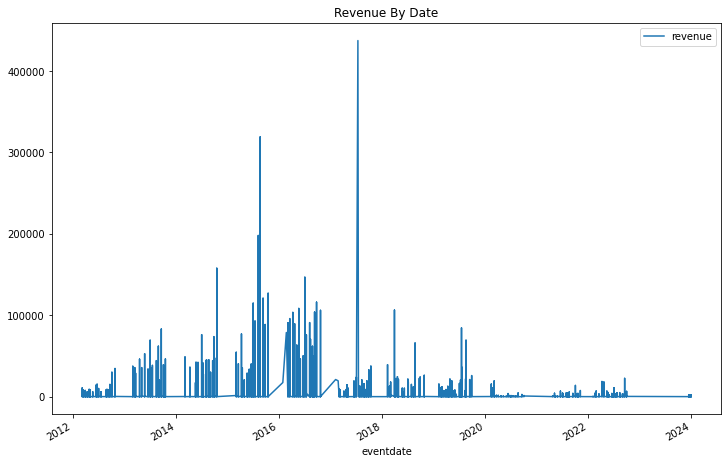

In [53]:
df.plot(x='eventdate', y='revenue', figsize=(12,8))
plt.title('Revenue By Date')

### Boxplot

We can see the number of purchases with a boxplot for the year. Showing the distribution is a little skewed to before 2018.

This however, doesn't display revenue well, as seen in the second visual. This shows that box charts are more useful when there is a fairly close distribution of data. With too much skew (such as in revenue), the chart will be too difficult to interpret. This can be minimized by selecting features, such as in the third and fourth box charts, where revenue is only readable for Mini Plan buyers.

From the matplotlib docs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
```
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR
```

<AxesSubplot:>

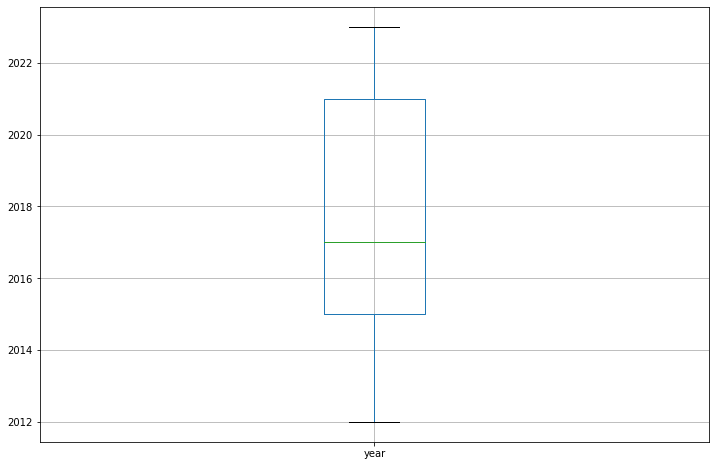

In [70]:
df.boxplot('year', figsize=(12, 8))

Text(0.5, 1.0, 'Revenue Box Chart')

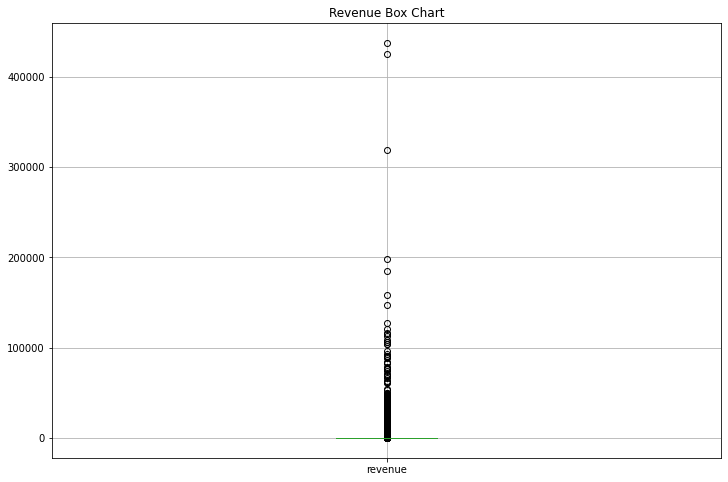

In [88]:
df.boxplot('revenue', figsize=(12, 8))
plt.title('Revenue Box Chart')

Text(0, 0.5, 'Revenue')

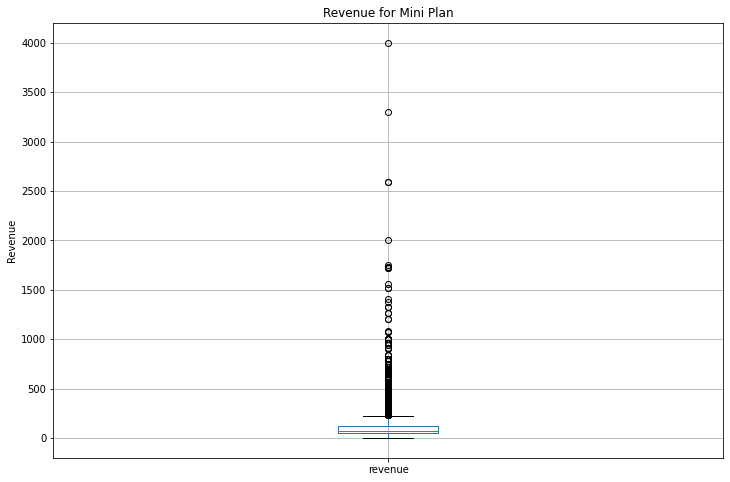

In [86]:
df[df['productgrouping'] == 'Mini Plan'].boxplot('revenue', figsize=(12, 8))
plt.title('Revenue for Mini Plan')

Here we pivot the data, as its current in format where we have a row per customer and a column for what type of plan they purchased. Now with the pivoted_df we have a row per customer and a column of how much they spent on each type of plan.

In [104]:
pivot_df = df.pivot(index=['id', 'year'], columns='productgrouping', values='revenue')

In [105]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 834657 entries, (1, 2012.0) to (916021, 2018.0)
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Full Season   533852 non-null  float64
 1   Group         75412 non-null   float64
 2   Individual    172723 non-null  float64
 3   Mini Plan     22216 non-null   float64
 4   Partial Plan  30454 non-null   float64
dtypes: float64(5)
memory usage: 74.4 MB


<AxesSubplot:>

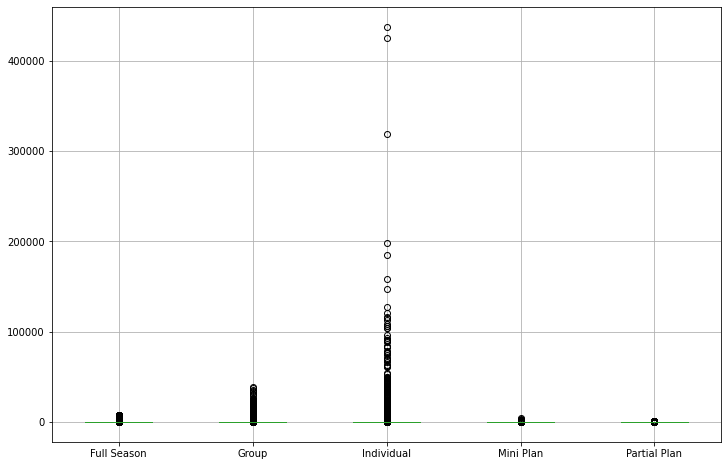

In [106]:
pivot_df[['Full Season', 'Group', 'Individual', 'Mini Plan', 'Partial Plan']].boxplot(figsize=(12,8))

Text(0, 0.5, 'Production')

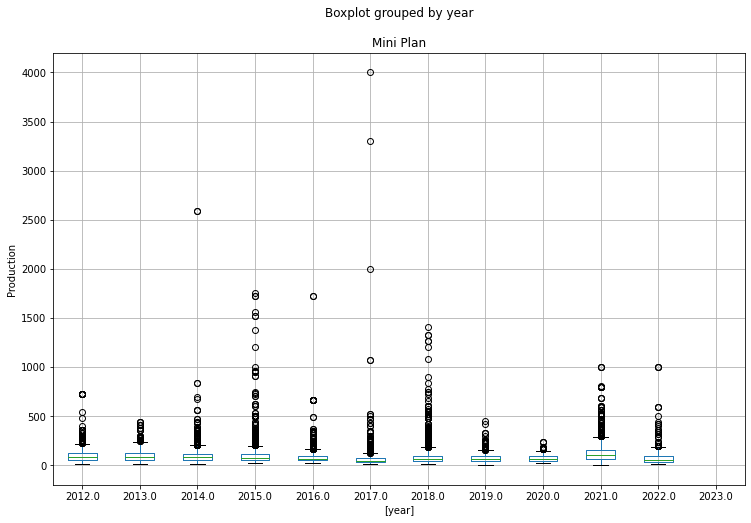

In [108]:
pivot_df.boxplot(column='Mini Plan', by=['year'], 
                       figsize=(12, 8))

plt.ylabel('Production')

### Bar Charts

Simpler to read total values by categorical groupings.

For some reason df.plot.bar took >20 minutes to run, so I used seaborn to run it.

This helps show categorical data, such as the product groupings and the variance in revenue per customer. Similarly, we could group by and sum the data for each product grouping to see the overall value of each grouping.

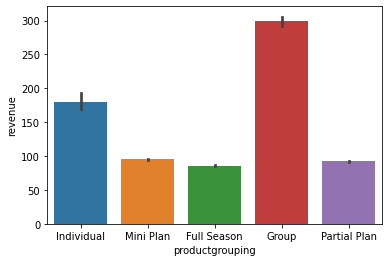

In [114]:
ax = sns.barplot(x="productgrouping", y="revenue", data=df)

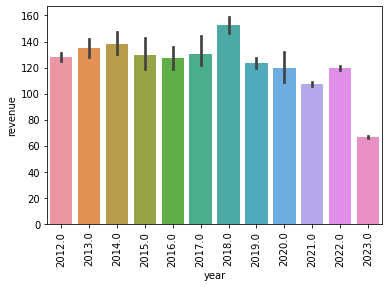

In [119]:
ax = sns.barplot(x="year", y="revenue", data=df)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

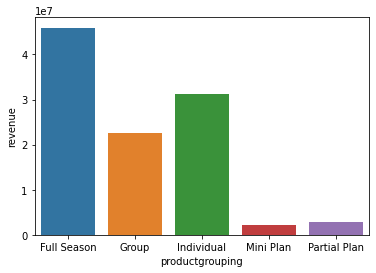

In [137]:
ax = sns.barplot(x="productgrouping", y="revenue", data=df.groupby('productgrouping', as_index=False).sum())

### KDE (Kernel Density Estimate)

This is basically how dense or sparse your data is. Similar to a histogram generally. Like a histogram it can help show the skew of your data, in particular it can help show how dense or sparse some areas of your data are.

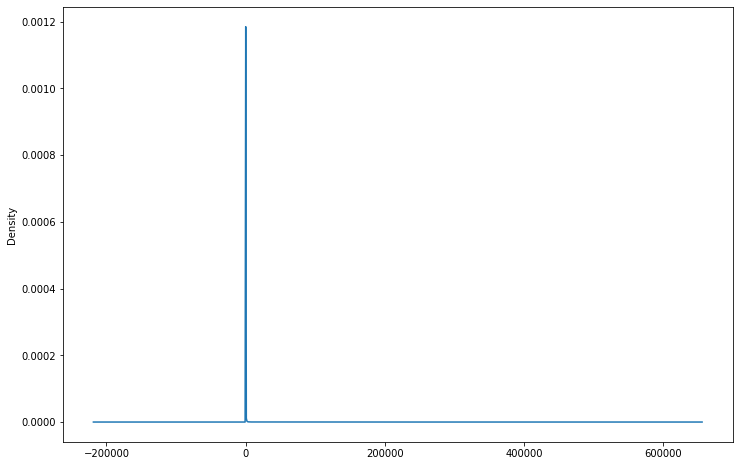

In [139]:
df['revenue'].plot.kde(figsize=(12,8))
plt.show()

### Scatter

Scatter plots help find relationships between points. Such as the plot below showing revenue and attendance count. You can see theres a possible correlation between how many games someone attends and how much they spend on a ticket, if they've gone to more games they could possibly want a better seat next time.

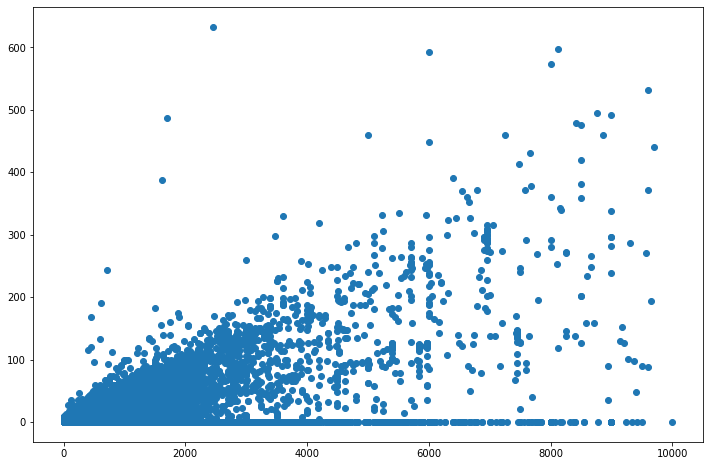

In [153]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['revenue']<10000]['revenue'], df[df['revenue']<10000]['attendancecount'])

<AxesSubplot:xlabel='revenue', ylabel='attendancecount'>

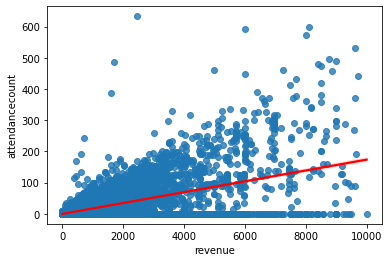

In [156]:
sns.regplot(x='revenue', y='attendancecount', data=df[df['revenue']<10000], line_kws={"color": "red"})

<AxesSubplot:xlabel='revenue', ylabel='attendancecount'>

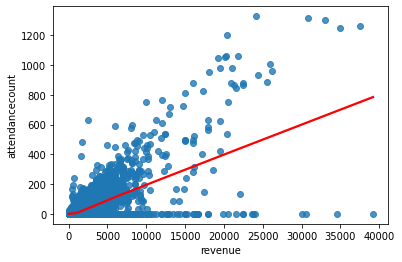

In [163]:
sns.regplot(x='revenue', y='attendancecount', data=df, line_kws={"color": "red"}, lowess=True)

### Heatmap

This helps show correlation between variables in your dataframe

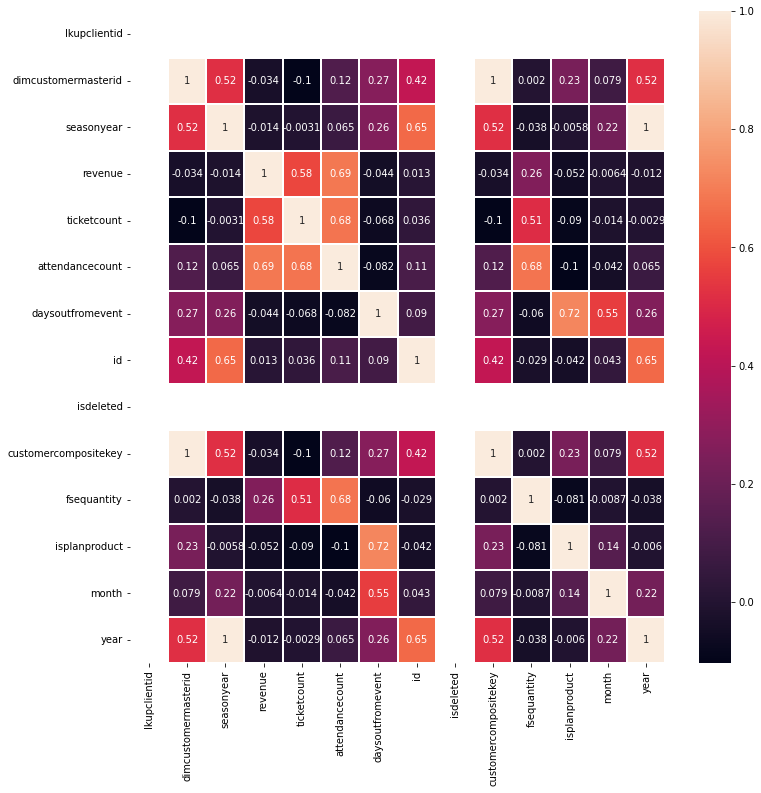

In [175]:
fig, ax = plt.subplots(figsize=(12,12))
corr = df.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=2)